# Validity of using prescription records to identify patient comorbidities
## Analysis of gord

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|OpenCodeList and HDRUK|
|drug codes|bnf selection|
|sql date|14.03.2025|
|sql code|gordselection20250313| 

In [1]:
    clear all

### Import from SQL server and data wrangling

In [2]:
odbc load, exec("select * from [gord_425000_20250313]") dsn("sqlserverconnect")

In [3]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab


egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab

replace bnf_code = "Antacides and simeticone" if bnf_code== "010101"
replace bnf_code = "Alginates" if bnf_code== "010102"
replace bnf_code = "H2receptor antagonists" if bnf_code== "010301"
replace bnf_code = "Proton pump inhibitors" if bnf_code== "010305"
replace bnf_code = "Other/unknown" if (missing(bnf_code) & ! missing(drug_dt))
replace bnf_code = "Other/unknown" if inlist(bnf_code, "010604","020101","020302","020505","020602","020900","021200")
replace bnf_code = "Other/unknown" if inlist(bnf_code, "040303","060201","060402","070402","080304","090101","090201","090604")





replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"




encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)

(110,083 missing values generated)
(110,083 real changes made)
(10,901 missing values generated)
(10,901 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str24
(778 real changes made)
(8,904 real changes made)
(7,483 real changes made)
(92,587 real changes made)
(48 real changes made)
(237 real changes made)
(42 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


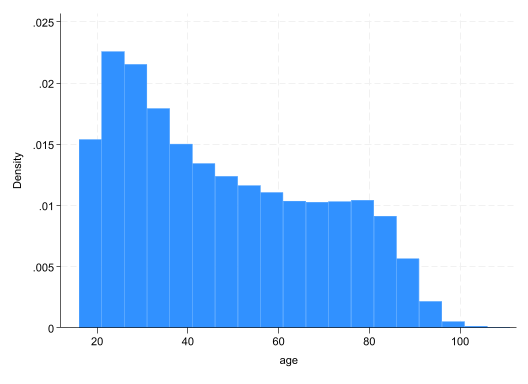

In [4]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [5]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +----------------------------------------------------------------------------------+
  |                                            description   Freq.   Percent     %<= |
  |----------------------------------------------------------------------------------|
  |                        Gastroesophageal reflux disease    3341     30.65   30.65 |
  |                      Gastro-oesophageal reflux disease    1349     12.38   43.02 |
  |                                            Esophagitis     794      7.28   50.31 |
  |                                         Gastric reflux     709      6.50   56.81 |
  |                                           Oesophagitis     648      5.94   62.76 |
  |----------------------------------------------------------------------------------|
  |       Gastroesophageal reflux disease with esophagitis     629      5.77   68.53 |
  |                                    Reflux oesophagitis     588      5.39   73.92 |
  |                                       

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [6]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +-----------------------------------------------------+
  |                 bnf_code   Freq.   Percent      %<= |
  |-----------------------------------------------------|
  |   Proton pump inhibitors   92587     84.11    84.11 |
  |                Alginates    8904      8.09    92.19 |
  |   H2receptor antagonists    7483      6.80    98.99 |
  | Antacides and simeticone     778      0.71    99.70 |
  |            Other/unknown     327      0.30   100.00 |
  +-----------------------------------------------------+


### Results
#### Overall

In [7]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    10,388        513 |    10,901 
    Normal |    99,695    314,404 |   414,099 
-----------+----------------------+----------
     Total |   110,083    314,917 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.3%     94.9%     95.7%
Specificity                      Pr(-|N)     75.9%     75.8%     76.1%
ROC area               (Sens. + Spec.)/2      0.86      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.96      3.

#### Males

In [8]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,921        272 |     5,193 
    Normal |    43,949    159,143 |   203,092 
-----------+----------------------+----------
     Total |    48,870    159,415 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.4%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.8%     94.1%     95.4%
Specificity                      Pr(-|N)     78.4%     78.2%     78.5%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.38      4.

#### Females

In [9]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,467        241 |     5,708 
    Normal |    55,745    155,253 |   210,998 
-----------+----------------------+----------
     Total |    61,212    155,494 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.6%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.8%     95.2%     96.3%
Specificity                      Pr(-|N)     73.6%     73.4%     73.8%
ROC area               (Sens. + Spec.)/2      0.85      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.63      3.

#### Age
*16-30*

In [10]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,320        115 |     1,435 
    Normal |    11,518    104,721 |   116,239 
-----------+----------------------+----------
     Total |    12,838    104,836 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.2%      1.2%       1.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     90.5%     93.3%
Specificity                      Pr(-|N)     90.1%     89.9%     90.3%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      9.28      9.

*30-69*

In [11]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,897        295 |     6,192 
    Normal |    50,135    165,068 |   215,203 
-----------+----------------------+----------
     Total |    56,032    165,363 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.7%       2.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.2%     94.7%     95.8%
Specificity                      Pr(-|N)     76.7%     76.5%     76.9%
ROC area               (Sens. + Spec.)/2      0.86      0.86      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.09      4.

*>69*

In [12]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,171        103 |     3,274 
    Normal |    38,042     44,615 |    82,657 
-----------+----------------------+----------
     Total |    41,213     44,718 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.8%      3.7%       3.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.9%     96.2%     97.4%
Specificity                      Pr(-|N)     54.0%     53.6%     54.3%
ROC area               (Sens. + Spec.)/2      0.75      0.75      0.76 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      2.10      2.

#### Year at start of oberservation period 
*2004-2009*

In [13]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,969        186 |     4,155 
    Normal |    32,761    113,084 |   145,845 
-----------+----------------------+----------
     Total |    36,730    113,270 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.7%       2.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     94.8%     96.1%
Specificity                      Pr(-|N)     77.5%     77.3%     77.8%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.25      4.

*2010-2015*

In [14]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,780        158 |     3,938 
    Normal |    36,457    109,605 |   146,062 
-----------+----------------------+----------
     Total |    40,237    109,763 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.0%     95.3%     96.6%
Specificity                      Pr(-|N)     75.0%     74.8%     75.3%
ROC area               (Sens. + Spec.)/2      0.86      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.85      3.

*2016-2020*

In [15]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,639        169 |     2,808 
    Normal |    30,477     91,715 |   122,192 
-----------+----------------------+----------
     Total |    33,116     91,884 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.2%      2.2%       2.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.0%     93.0%     94.8%
Specificity                      Pr(-|N)     75.1%     74.8%     75.3%
ROC area               (Sens. + Spec.)/2      0.85      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.77      3.

#### IMD of practice
*1-3*

In [16]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,789        199 |     3,988 
    Normal |    36,966    113,597 |   150,563 
-----------+----------------------+----------
     Total |    40,755    113,796 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     94.3%     95.7%
Specificity                      Pr(-|N)     75.4%     75.2%     75.7%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.87      3.

*4-7*

In [17]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,644        154 |     3,798 
    Normal |    35,435    103,812 |   139,247 
-----------+----------------------+----------
     Total |    39,079    103,966 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.6%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.9%     95.3%     96.6%
Specificity                      Pr(-|N)     74.6%     74.3%     74.8%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.77      3.

*8-10*

In [18]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,912        153 |     3,065 
    Normal |    27,080     94,670 |   121,750 
-----------+----------------------+----------
     Total |    29,992     94,823 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.4%       2.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     94.2%     95.8%
Specificity                      Pr(-|N)     77.8%     77.5%     78.0%
ROC area               (Sens. + Spec.)/2      0.86      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.27      4.

#### Commissioning Regions
EAST OF ENGLAND

In [19]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,297        109 |     2,406 
    Normal |    22,003     65,228 |    87,231 
-----------+----------------------+----------
     Total |    24,300     65,337 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.6%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     94.6%     96.3%
Specificity                      Pr(-|N)     74.8%     74.5%     75.1%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.78      3.

London

In [20]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       278         28 |       306 
    Normal |     2,486     13,933 |    16,419 
-----------+----------------------+----------
     Total |     2,764     13,961 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.6%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     90.8%     87.0%     93.8%
Specificity                      Pr(-|N)     84.9%     84.3%     85.4%
ROC area               (Sens. + Spec.)/2      0.88      0.86      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.00      5.

Midlands

In [21]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,269         57 |     1,326 
    Normal |    12,189     33,028 |    45,217 
-----------+----------------------+----------
     Total |    13,458     33,085 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.7%       3.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.7%     94.5%     96.7%
Specificity                      Pr(-|N)     73.0%     72.6%     73.5%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.55      3.

Yorkshire

In [22]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,196        115 |     2,311 
    Normal |    21,000     62,800 |    83,800 
-----------+----------------------+----------
     Total |    23,196     62,915 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.6%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     94.1%     95.9%
Specificity                      Pr(-|N)     74.9%     74.6%     75.2%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.79      3.

North West

In [23]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,287         68 |     1,355 
    Normal |    10,034     36,204 |    46,238 
-----------+----------------------+----------
     Total |    11,321     36,272 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.8%      2.7%       3.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     93.7%     96.1%
Specificity                      Pr(-|N)     78.3%     77.9%     78.7%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.38      4.

South East

In [24]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,995         99 |     2,094 
    Normal |    19,335     69,056 |    88,391 
-----------+----------------------+----------
     Total |    21,330     69,155 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.3%      2.2%       2.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.3%     94.3%     96.1%
Specificity                      Pr(-|N)     78.1%     77.9%     78.4%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.36      4.

South West

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       823         30 |       853 
    Normal |     9,977     25,346 |    35,323 
-----------+----------------------+----------
     Total |    10,800     25,376 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.4%      2.2%       2.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     96.5%     95.0%     97.6%
Specificity                      Pr(-|N)     71.8%     71.3%     72.2%
ROC area               (Sens. + Spec.)/2      0.84      0.83      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.42      3.

#### System
SystmOne

In [26]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,662        276 |     5,938 
    Normal |    58,024    164,793 |   222,817 
-----------+----------------------+----------
     Total |    63,686    165,069 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.4%     94.8%     95.9%
Specificity                      Pr(-|N)     74.0%     73.8%     74.1%
ROC area               (Sens. + Spec.)/2      0.85      0.84      0.85 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.66      3.

Vision

In [27]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       324          9 |       333 
    Normal |     3,201     10,210 |    13,411 
-----------+----------------------+----------
     Total |     3,525     10,219 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.4%      2.2%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     97.3%     94.9%     98.8%
Specificity                      Pr(-|N)     76.1%     75.4%     76.9%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.08      3.

EMIS

In [28]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,399        227 |     4,626 
    Normal |    38,427    139,312 |   177,739 
-----------+----------------------+----------
     Total |    42,826    139,539 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.5%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.1%     94.4%     95.7%
Specificity                      Pr(-|N)     78.4%     78.2%     78.6%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.40      4.

#### RA_Index
Index==1

In [29]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,965        386 |     8,351 
    Normal |    75,204    238,142 |   313,346 
-----------+----------------------+----------
     Total |    83,169    238,528 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.6%      2.5%       2.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.4%     94.9%     95.8%
Specificity                      Pr(-|N)     76.0%     75.8%     76.1%
ROC area               (Sens. + Spec.)/2      0.86      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.97      3.

Index==0

In [30]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,423        127 |     2,550 
    Normal |    24,491     76,262 |   100,753 
-----------+----------------------+----------
     Total |    26,914     76,389 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.4%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     94.1%     95.8%
Specificity                      Pr(-|N)     75.7%     75.4%     76.0%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.91      3.

#### Ethnicity
Ethnicity==0000white

In [31]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,163        359 |     7,522 
    Normal |    69,010    181,449 |   250,459 
-----------+----------------------+----------
     Total |    76,173    181,808 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.9%      2.9%       3.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.2%     94.7%     95.7%
Specificity                      Pr(-|N)     72.4%     72.3%     72.6%
ROC area               (Sens. + Spec.)/2      0.84      0.84      0.84 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.46      3.

In [32]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,030         56 |     1,086 
    Normal |     9,656     33,126 |    42,782 
-----------+----------------------+----------
     Total |    10,686     33,182 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.5%      2.3%       2.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.8%     93.4%     96.1%
Specificity                      Pr(-|N)     77.4%     77.0%     77.8%
ROC area               (Sens. + Spec.)/2      0.86      0.85      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.20      4.

In [33]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,195         98 |     2,293 
    Normal |    21,029     99,829 |   120,858 
-----------+----------------------+----------
     Total |    23,224     99,927 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.9%      1.8%       1.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.7%     94.8%     96.5%
Specificity                      Pr(-|N)     82.6%     82.4%     82.8%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.50      5.

In [34]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [35]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [36]:
logistic diag_pos if test==1


Logistic regression                                    Number of obs = 109,825
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -34280.584                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   .1039908   .0010743  -219.11   0.000     .1019064    .1061177
------------------------------------------------------------------------------


In [37]:
logistic diag_pos i.bnf_code_values if test==1

note: 1.bnf_code_values != 0 predicts failure perfectly;
      1.bnf_code_values omitted and 2 obs not used.

note: 2.bnf_code_values != 0 predicts failure perfectly;
      2.bnf_code_values omitted and 1 obs not used.

note: 3.bnf_code_values != 0 predicts failure perfectly;
      3.bnf_code_values omitted and 1 obs not used.

note: 8.bnf_code_values omitted because of collinearity.

Logistic regression                                    Number of obs = 109,821
                                                       LR chi2(4)    =   20.74
                                                       Prob > chi2   =  0.0004
Log likelihood = -34269.82                             Pseudo R2     =  0.0003

-------------------------------------------------------------------------------------------
                 diag_pos | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
--------------------------+----------------------------------------------------------------
          bnf_code_

In [38]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -34438.241  
Iteration 1:  Log likelihood = -33899.795  
Iteration 2:  Log likelihood = -33897.885  
Iteration 3:  Log likelihood = -33897.885  

Refining starting values:

Grid node 0:  Log likelihood = -33651.057

Fitting full model:

Iteration 0:  Log likelihood = -33651.057  (not concave)
Iteration 1:  Log likelihood = -33541.584  
Iteration 2:  Log likelihood = -33535.286  
Iteration 3:  Log likelihood = -33534.852  
Iteration 4:  Log likelihood = -33534.852  

Mixed-effects logistic regression               Number of obs     =    109,457
Group variable: practice_id                     Number of groups  =        328

                                                Obs per group:
                                                              min =          1
                                                              avg =      333.7
                                                              max =      3,287

Integra

##### Likelihood ratio tests

In [39]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [40]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) =  32.32
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) = 197.09
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 271.67
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) =   7.41
Prob > chi2 = 0.0245

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =   6.22
Prob > chi2 = 0.0446


#### NPV

In [41]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 312,577
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -3757.1814                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   616.7411   27.43971   144.40   0.000     565.2385    672.9365
------------------------------------------------------------------------------


In [42]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -27699.388  
Iteration 1:  Log likelihood = -4000.5793  
Iteration 2:  Log likelihood = -3724.6583  
Iteration 3:  Log likelihood = -3707.6709  
Iteration 4:  Log likelihood = -3707.5579  
Iteration 5:  Log likelihood = -3707.5579  

Refining starting values:

Grid node 0:  Log likelihood = -3714.4467

Fitting full model:

Iteration 0:  Log likelihood = -3714.4467  (not concave)
Iteration 1:  Log likelihood = -3695.5908  
Iteration 2:  Log likelihood = -3689.9483  
Iteration 3:  Log likelihood = -3688.3333  
Iteration 4:  Log likelihood = -3688.3007  
Iteration 5:  Log likelihood = -3688.3006  

Mixed-effects logistic regression               Number of obs     =    311,976
Group variable: practice_id                     Number of groups  =        336

                                                Obs per group:
                                                              min =          1
      

##### Likelihood ratio tests

In [43]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [44]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =   2.28
Prob > chi2 = 0.1311

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =   7.13
Prob > chi2 = 0.0283

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) =  32.11
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =  38.21
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   0.39
Prob > chi2 = 0.8239


In [45]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) export(validity2.xlsx, modify sheet(reg_gord, replace))


Table 2. PPV (1) and NPV (2), OR, Random effect
-------------------------------------------------------------------
                                                    1         2    
-------------------------------------------------------------------
sex_coded                                                          
  1                                               1.13 **   0.87   
yearcat                                                            
  2010-2015                                       0.81 **   1.33 * 
  2016-2020                                       0.67 **   1.07   
agecat                                                             
  0Middle                                         1.00      0.64 **
  Elderly                                         0.69 **   0.46 **
region                                                             
  LONDON COMMISSIONING REGION                     0.93      0.78   
  MIDLANDS COMMISSIONING REGION                   1.08      0.88   

### Summary of validation parameters

In [46]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [47]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,2.6,95.3,75.9,9.4,99.8,.86,25.9
2,Male,2.5,94.8,78.4,10.1,99.8,.87,23.5
3,Female,2.6,95.8,73.6,8.9,99.8,.85,28.2
4,Age young,1.2,92,90.1,10.3,99.9,.91,10.9
5,Age middle,2.8,95.2,76.7,10.5,99.8,.86,25.3
6,Age elderly,3.8,96.9,54,7.7,99.8,.75,48
7,Year 2004-2009,2.8,95.5,77.5,10.8,99.8,.87,24.5
8,Year 2010-2015,2.6,96,75,9.4,99.9,.86,26.8
9,Year 2016-2020,2.2,94,75.1,8,99.8,.85,26.5
10,"IMD 1,3",2.6,95,75.4,9.3,99.8,.85,26.4


In [48]:
/*texsave * using test3.tex, varlabels*/
export excel using  validity2.xlsx, sheet(val_gord, replace)

file validity2.xlsx saved
